In [1]:
import efficient_kan
from efficient_kan import KAN, KANLinear
import torch

from torch import nn
from torch import optim
from torch.functional import F
from torch.distributions import Categorical, MixtureSameFamily, MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from chebykanlayer import ChebyKANLayer
from fourierkanlayer import NaiveFourierKANLayer
from helper_functions import *
from kan_mixture_models import *

from scipy import special
import math

### Create toy datasets

| Dataset Name | Function | Dimensionality | Formula |
|--------------|----------|----------------|---------|
| Bessel Function | $f(x)$ | 1D | $J_0(20x)$ |
| Exp-Sin-Square | $f(x, y)$ | 2D | $\exp(\sin(\pi x) + y^2)$ |
| Multiplication | $f(x, y)$ | 2D | $xy$ |
| High-Dimensional | $f(x_1, \ldots, x_{100})$ | 100D | $\exp(\frac{1}{100} \sum_{i=1}^{100} \sin^2(\frac{\pi x_i}{2}))$ |
| Four-Dimensional | $f(x_1, x_2, x_3, x_4)$ | 4D | $\exp(\frac{1}{2}(\sin(\pi(x_1^2 + x_2^2)) + \sin(\pi(x_3^2 + x_4^2))))$ |

In [2]:
def bessel_dataset(num_samples=1000, x_range=(-1, 1)):
    x = torch.linspace(x_range[0], x_range[1], num_samples).unsqueeze(1)
    y = torch.tensor([special.jv(0, 20*xi.item()) for xi in x]).unsqueeze(1)
    return x, y

def exp_sin_square_dataset(num_samples=1000, x_range=(-1, 1), y_range=(-1, 1)):
    x = torch.rand(num_samples, 1) * (x_range[1] - x_range[0]) + x_range[0]
    y = torch.rand(num_samples, 1) * (y_range[1] - y_range[0]) + y_range[0]
    z = torch.exp(torch.sin(math.pi * x) + y**2)
    return torch.cat([x, y], dim=1), z

def multiplication_dataset(num_samples=1000, x_range=(-1, 1), y_range=(-1, 1)):
    x = torch.rand(num_samples, 1) * (x_range[1] - x_range[0]) + x_range[0]
    y = torch.rand(num_samples, 1) * (y_range[1] - y_range[0]) + y_range[0]
    z = x * y
    return torch.cat([x, y], dim=1), z

def high_dim_dataset(num_samples=1000, dim=100, x_range=(-1, 1)):
    x = torch.rand(num_samples, dim) * (x_range[1] - x_range[0]) + x_range[0]
    y = torch.exp(torch.mean(torch.sin(math.pi * x / 2)**2, dim=1, keepdim=True))
    return x, y

def four_dim_dataset(num_samples=1000, x_range=(-1, 1)):
    x = torch.rand(num_samples, 4) * (x_range[1] - x_range[0]) + x_range[0]
    y = torch.exp(0.5 * (torch.sin(math.pi * (x[:, 0]**2 + x[:, 1]**2)) + 
                         torch.sin(math.pi * (x[:, 2]**2 + x[:, 3]**2)))).unsqueeze(1)
    return x, y

In [3]:
x1, y1 = bessel_dataset()
x2, y2 = exp_sin_square_dataset()
x3, y3 = multiplication_dataset()
x4, y4 = high_dim_dataset()
x5, y5 = four_dim_dataset()

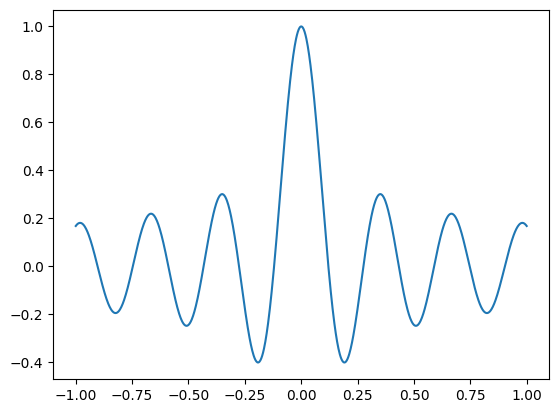

In [4]:
plt.plot(x1, y1)

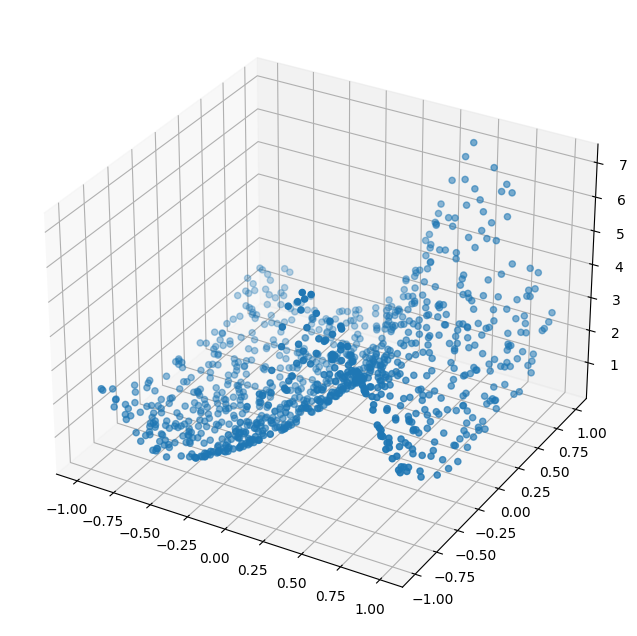

In [5]:
fig = plt.figure(figsize=(12,8))
axes = plt.subplot(1,1,1, projection="3d")

axes.scatter(x2[:, 0], x2[:, 1], y2)

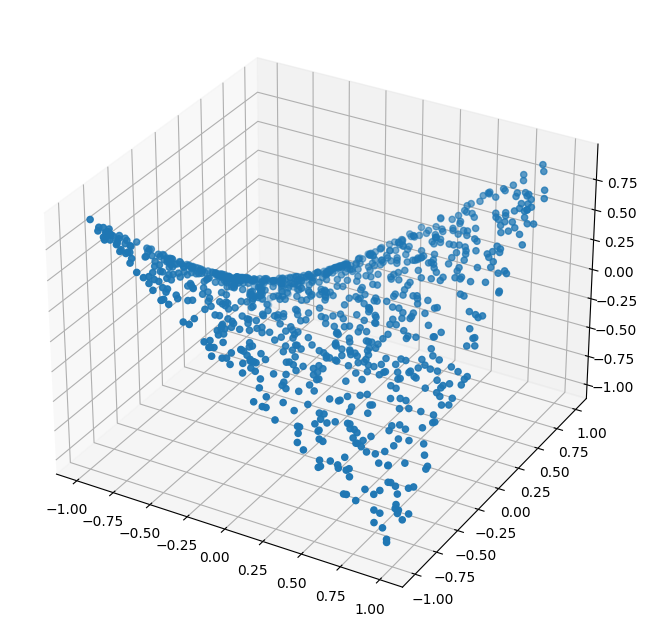

In [6]:
fig = plt.figure(figsize=(12,8))
axes = plt.subplot(1,1,1, projection="3d")

axes.scatter(x3[:, 0], x3[:, 1], y3)

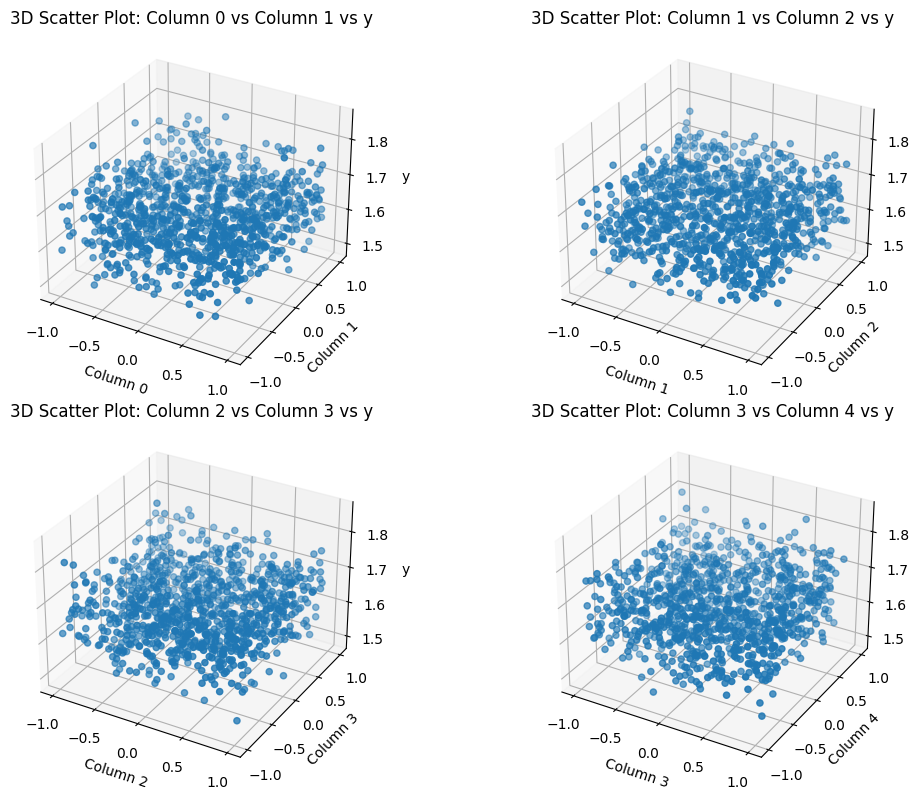

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(12, 8))


for i in range(4):
    axes = fig.add_subplot(2, 2, i+1, projection="3d")
    axes.scatter(x4[:, i], x4[:, i+1], y4)
    axes.set_xlabel(f'Column {i}')
    axes.set_ylabel(f'Column {i+1}')
    axes.set_zlabel('y')
    axes.set_title(f'3D Scatter Plot: Column {i} vs Column {i+1} vs y')

plt.tight_layout()
plt.show()

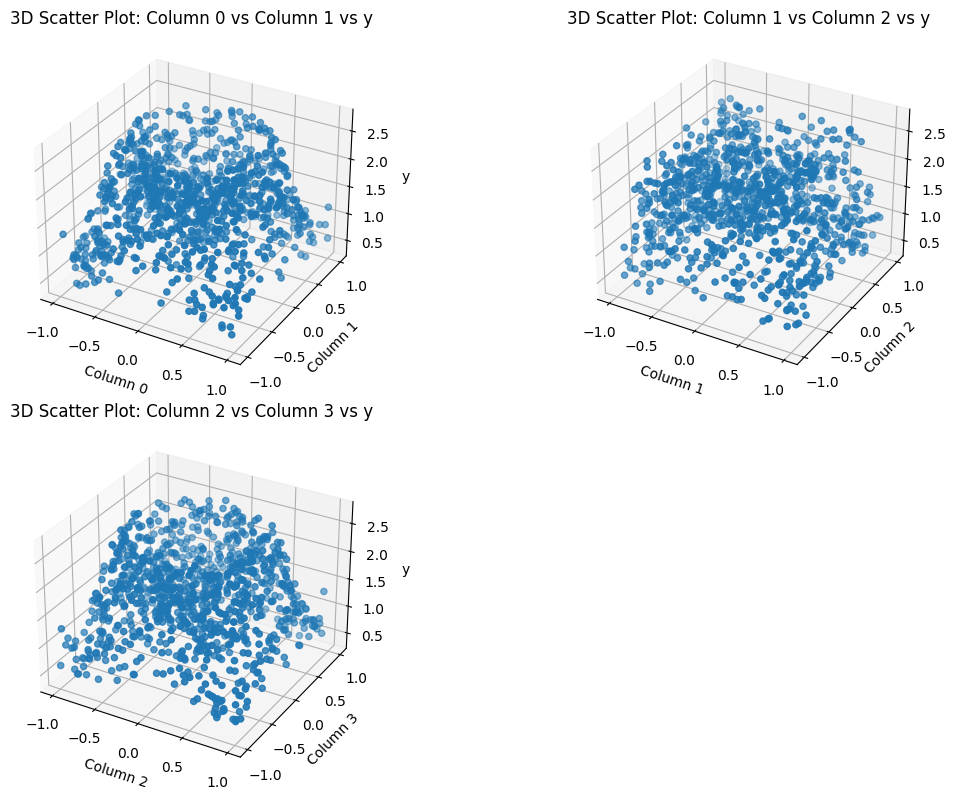

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(12, 8))


for i in range(0,3):
    axes = fig.add_subplot(2, 2, i+1, projection="3d")
    axes.scatter(x5[:, i], x5[:, i+1], y5)
    axes.set_xlabel(f'Column {i}')
    axes.set_ylabel(f'Column {i+1}')
    axes.set_zlabel('y')
    axes.set_title(f'3D Scatter Plot: Column {i} vs Column {i+1} vs y')

plt.tight_layout()
plt.show()

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [284]:
multikan = MultivariateKANMixtureDensityNetwork(input_dim=x1.shape[1], 
                                                output_dim=1, hidden_dim=30, 
                                                n_mixtures=3, 
                                                grid_size=10, 
                                                spline_order=5).to(device)

multimdn = MixtureDensityNetwork(input_dim=x1.shape[1], 
                                 output_dim=1, 
                                 hidden_dim=30, n_mixtures=3, 
                                 n_hidden_layers=2).to(device)  # the kan also has 2 hidden layers implicitly

In [285]:

optimizerkan = torch.optim.Adam(params=multikan.parameters(), 
                             lr=0.001, weight_decay=1e-5)

optimizermdn = torch.optim.Adam(params=multimdn.parameters(), 
                             lr=0.001, weight_decay=1e-5)

In [286]:
pi_kan, mu_kan, sigma_kan = training_process(multikan, mdn_loss, optimizerkan, 3000, x1.to(device), y1.to(device))

Epoch: 0 | Loss: 0.96417
Epoch: 100 | Loss: -0.07021
Epoch: 200 | Loss: -0.45581
Epoch: 300 | Loss: -1.16135
Epoch: 400 | Loss: -1.82222
Epoch: 500 | Loss: -2.40481
Epoch: 600 | Loss: -1.45456
Epoch: 700 | Loss: -3.23706
Epoch: 800 | Loss: -3.50912
Epoch: 900 | Loss: -3.43612
Epoch: 1000 | Loss: -3.72118
Epoch: 1100 | Loss: -3.34070
Epoch: 1200 | Loss: -3.13765
Epoch: 1300 | Loss: -3.54953
Epoch: 1400 | Loss: -3.76792
Epoch: 1500 | Loss: -3.83493
Epoch: 1600 | Loss: -4.03630
Epoch: 1700 | Loss: -4.14810
Epoch: 1800 | Loss: -4.30083
Epoch: 1900 | Loss: -4.18696
Epoch: 2000 | Loss: -4.34959
Epoch: 2100 | Loss: -4.34513
Epoch: 2200 | Loss: -3.96337
Epoch: 2300 | Loss: -2.99575
Epoch: 2400 | Loss: -4.57781
Epoch: 2500 | Loss: -4.12012
Epoch: 2600 | Loss: -3.98530
Epoch: 2700 | Loss: -4.33742
Epoch: 2800 | Loss: -4.13200
Epoch: 2900 | Loss: -3.97142


In [287]:
pi, mu, sigma = training_process(multimdn, mdn_loss, optimizermdn, 3000, x1.to(device), y1.to(device))

Epoch: 0 | Loss: 0.92133
Epoch: 100 | Loss: -0.04257
Epoch: 200 | Loss: -0.21546
Epoch: 300 | Loss: -0.31564
Epoch: 400 | Loss: -0.36511
Epoch: 500 | Loss: -0.39598
Epoch: 600 | Loss: -0.43225
Epoch: 700 | Loss: -0.48203
Epoch: 800 | Loss: -0.56851
Epoch: 900 | Loss: -0.56492
Epoch: 1000 | Loss: -0.64322
Epoch: 1100 | Loss: -0.64666
Epoch: 1200 | Loss: -0.63505
Epoch: 1300 | Loss: -0.73082
Epoch: 1400 | Loss: -0.71629
Epoch: 1500 | Loss: -0.73958
Epoch: 1600 | Loss: -0.79883
Epoch: 1700 | Loss: -0.80237
Epoch: 1800 | Loss: -0.85068
Epoch: 1900 | Loss: -0.85853
Epoch: 2000 | Loss: -0.87302
Epoch: 2100 | Loss: -0.88353
Epoch: 2200 | Loss: -0.90203
Epoch: 2300 | Loss: -0.85839
Epoch: 2400 | Loss: -0.89605
Epoch: 2500 | Loss: -0.92576
Epoch: 2600 | Loss: -0.95022
Epoch: 2700 | Loss: -0.95402
Epoch: 2800 | Loss: -0.96163
Epoch: 2900 | Loss: -0.94950


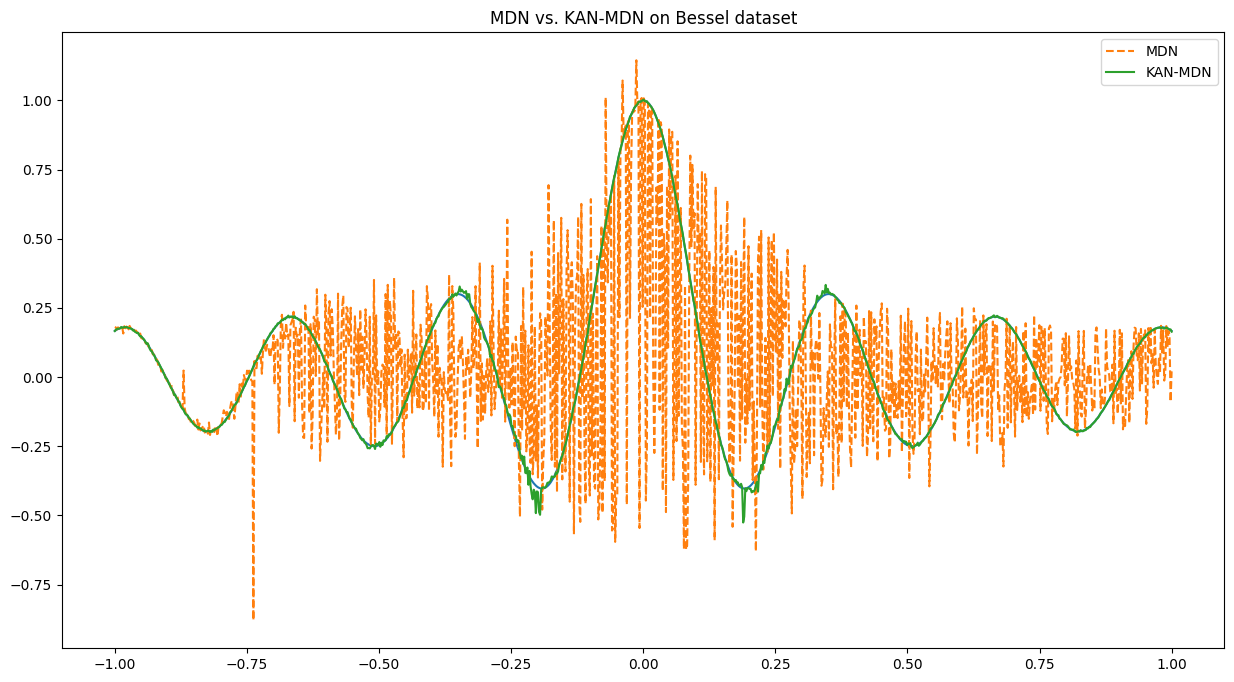

In [288]:
samples_kan = sample_from_mdn(pi_kan, mu_kan, sigma_kan, num_samples=1).reshape(-1, 1)
samples = sample_from_mdn(pi, mu, sigma, num_samples=1).reshape(-1, 1)

plt.figure(figsize=(15,8))
plt.plot(x1, y1)
plt.plot(x1, samples.detach().cpu(), label="MDN", linestyle="--")
plt.plot(x1, samples_kan.detach().cpu(), label="KAN-MDN")

plt.title("MDN vs. KAN-MDN on Bessel dataset")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


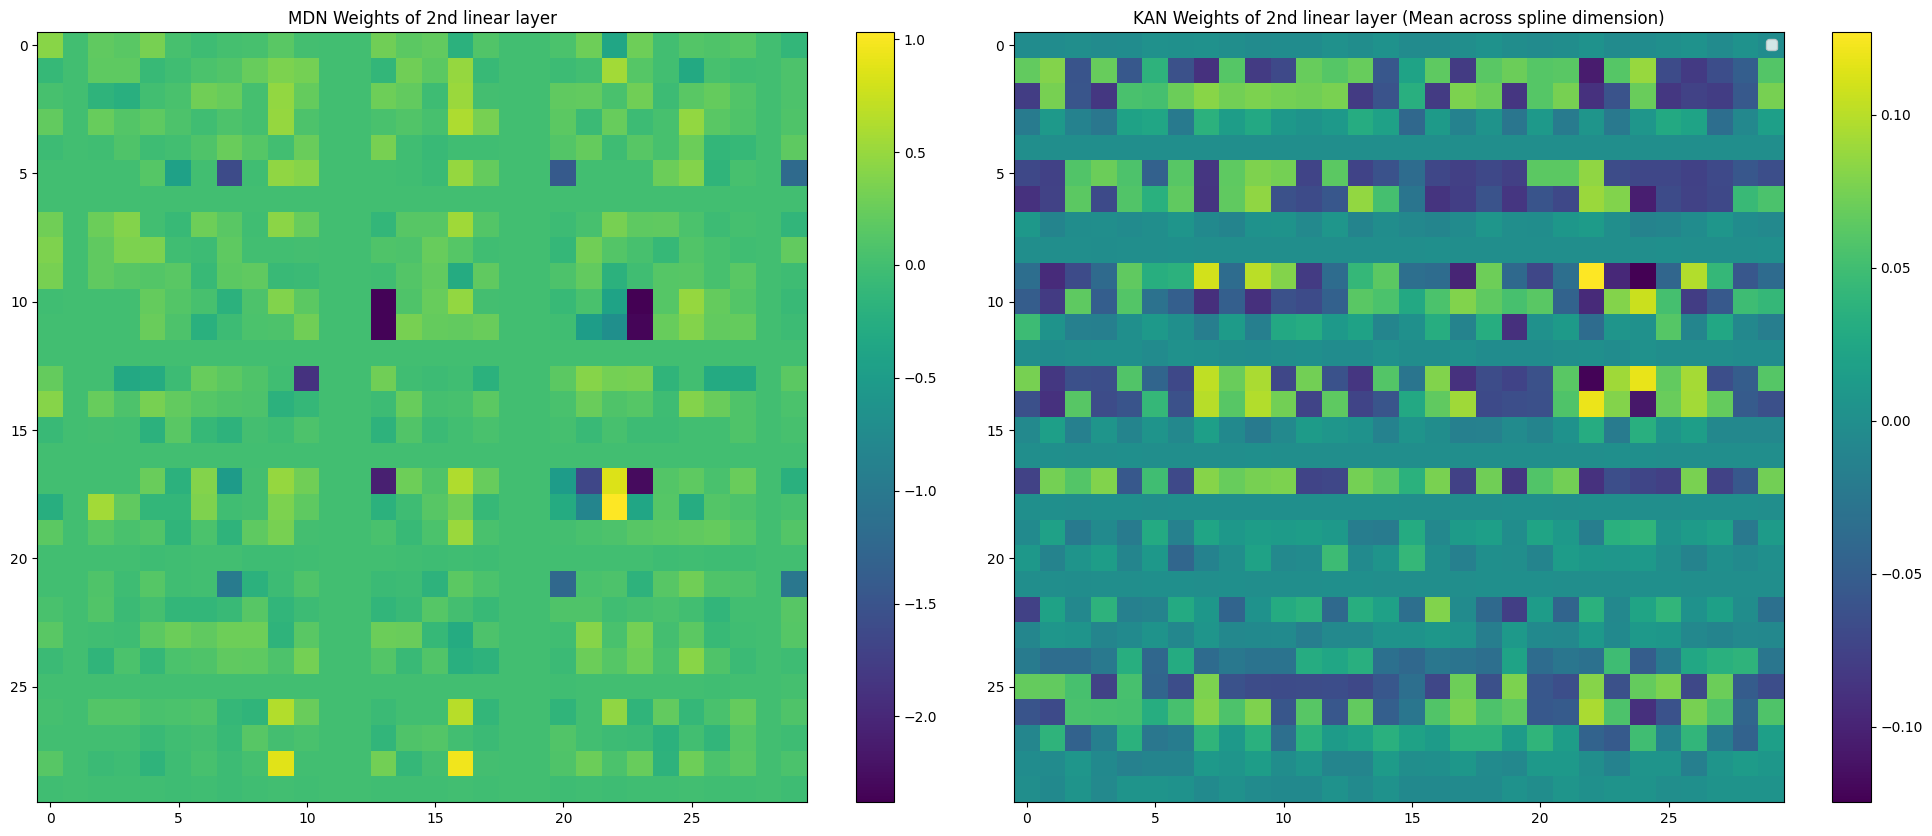

In [289]:


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First subplot
im1 = ax1.imshow(multimdn.hidden_block[2].weight.detach().cpu().numpy(),)
ax1.set_title('MDN Weights of 2nd linear layer')
fig.colorbar(im1, ax=ax1)

# Second subplot
im2 = ax2.imshow(multikan.hidden_block[2].spline_weight.detach().cpu().numpy().mean(axis=2),)
ax2.set_title('KAN Weights of 2nd linear layer (Mean across spline dimension)')
fig.colorbar(im2, ax=ax2)

# Adjust layout and display
plt.tight_layout()
plt.legend()

In [22]:
multikan_2 = MultivariateKANMixtureDensityNetwork(input_dim=x2.shape[1], 
                                                  output_dim=1, 
                                                  hidden_dim=30, 
                                                  n_mixtures=3, 
                                                  grid_size=5, 
                                                  spline_order=3).to(device)

multimdn_2 = MixtureDensityNetwork(input_dim=x2.shape[1], 
                                 output_dim=1, 
                                 hidden_dim=30, 
                                 n_mixtures=3, 
                                 n_hidden_layers=2).to(device)  # the kan also has 2 hidden layers implicitly

In [25]:

optimizerkan_2 = torch.optim.Adam(params=multikan_2.parameters(), 
                             lr=0.001)

optimizermdn_2 = torch.optim.Adam(params=multimdn_2.parameters(), 
                             lr=0.001)

In [24]:
pi_kan2, mu_kan2, sigma_kan2 = training_process(multikan_2, mdn_loss, optimizerkan_2, 500, x2.to(device), y2.to(device))

Epoch: 0 | Loss: 3.49997
Epoch: 100 | Loss: 1.61713
Epoch: 200 | Loss: -0.03687
Epoch: 300 | Loss: -2.61334
Epoch: 400 | Loss: -3.35615


In [26]:

pi_2, mu_2, sigma_2 = training_process(multimdn_2, mdn_loss, optimizermdn_2, 500, x2.to(device), y2.to(device))

Epoch: 0 | Loss: 2.99155
Epoch: 100 | Loss: 1.35102
Epoch: 200 | Loss: 0.40927
Epoch: 300 | Loss: -0.47055
Epoch: 400 | Loss: -0.85020


In [27]:
samples_kan2 = sample_from_mdn(pi_kan2, mu_kan2, sigma_kan2, num_samples=1).reshape(-1, 1)
samples_2 = sample_from_mdn(pi_2, mu_2, sigma_2 , num_samples=1).reshape(-1, 1)

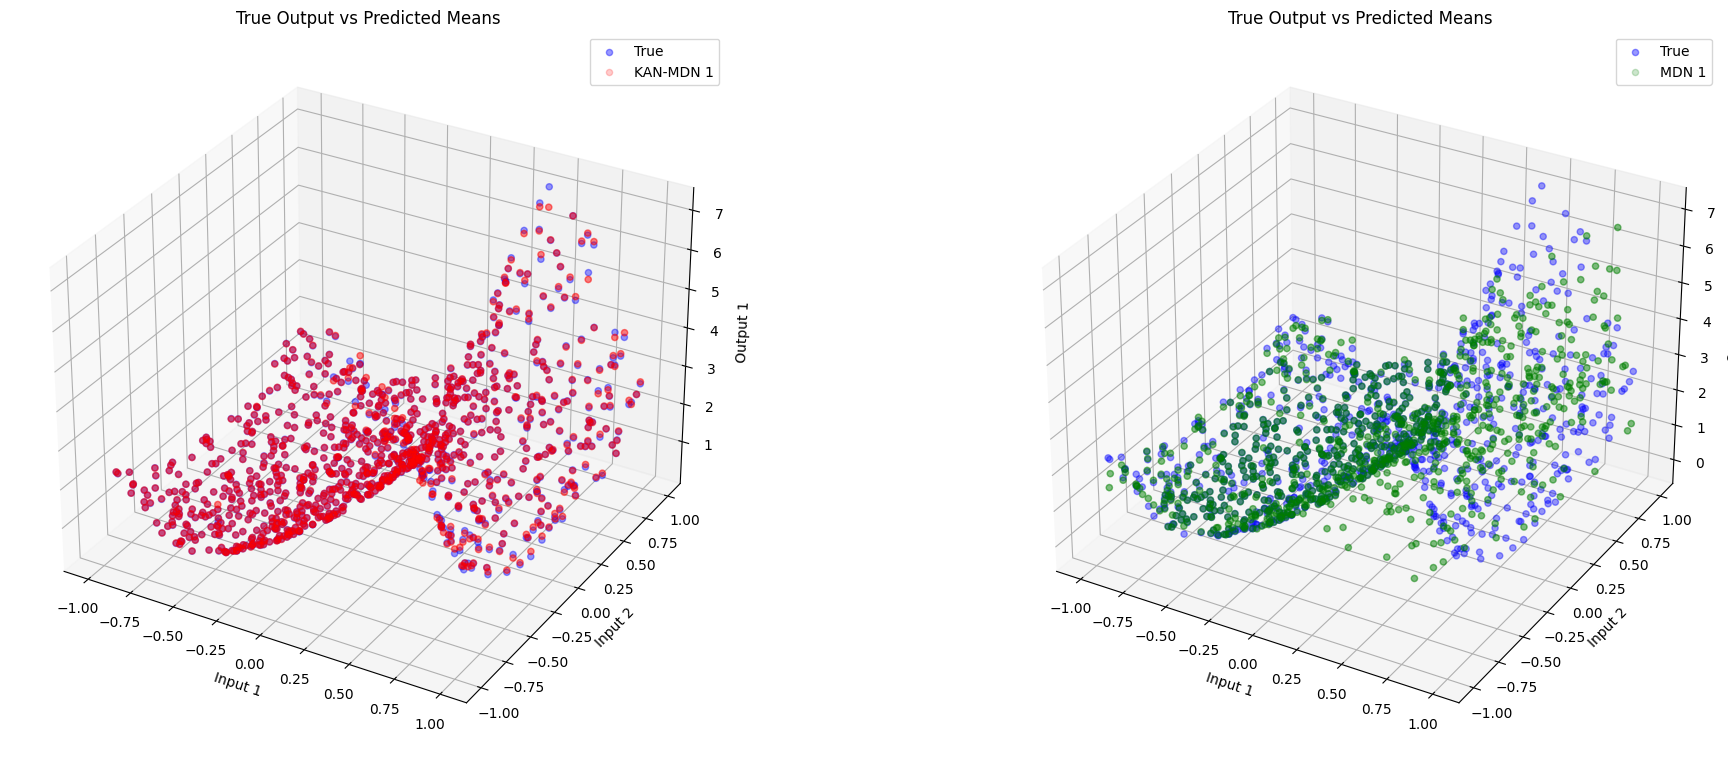

In [33]:
fig = plt.figure(figsize=(20, 15))
# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(x2[:, 0], x2[:, 1], y2, c='b', alpha=0.4, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(x2[:, 0], x2[:, 1], samples_kan2.detach().cpu(), c='r', alpha=0.2, label=f'KAN-MDN {i+1}' if i == 0 else "")
    # ax1.scatter(x2[:, 0], x2[:, 1], samples_2.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_zlabel('Output 1')
ax1.set_title('True Output vs Predicted Means')
ax1.legend()



ax2 = fig.add_subplot(222, projection='3d')
scatter = ax2.scatter(x2[:, 0], x2[:, 1], y2, c='b', alpha=0.4, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax2.scatter(x2[:, 0], x2[:, 1], samples_2.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
    # ax1.scatter(x2[:, 0], x2[:, 1], samples_2.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
ax2.set_xlabel('Input 1')
ax2.set_ylabel('Input 2')
ax2.set_zlabel('Output 1')
ax2.set_title('True Output vs Predicted Means')
ax2.legend()
plt.tight_layout()
plt.show()

In [379]:
multikan_3 = MultivariateKANMixtureDensityNetwork(input_dim=x3.shape[1], 
                                                  output_dim=1, 
                                                  hidden_dim=30, 
                                                  n_mixtures=3, 
                                                  grid_size=5, 
                                                  spline_order=3).to(device)

multimdn_3 = MixtureDensityNetwork(input_dim=x3.shape[1], 
                                 output_dim=1, 
                                 hidden_dim=30, 
                                 n_mixtures=3, 
                                 n_hidden_layers=2).to(device)  # the kan also has 2 hidden layers implicitly

In [380]:

optimizerkan_3 = torch.optim.Adam(params=multikan_3.parameters(), 
                             lr=0.001)

optimizermdn_3 = torch.optim.Adam(params=multimdn_3.parameters(), 
                             lr=0.001)

In [381]:
pi_kan3, mu_kan3, sigma_kan3 = training_process(multikan_3, mdn_loss, optimizerkan_3, 500, x3.to(device), y3.to(device))

Epoch: 0 | Loss: 0.97405
Epoch: 100 | Loss: -1.33569
Epoch: 200 | Loss: -3.56834
Epoch: 300 | Loss: -3.01376
Epoch: 400 | Loss: -2.00652


In [382]:

pi_3, mu_3, sigma_3 = training_process(multimdn_3, mdn_loss, optimizermdn_3, 500, x3.to(device), y3.to(device))

Epoch: 0 | Loss: 1.01324
Epoch: 100 | Loss: -1.51475
Epoch: 200 | Loss: -2.49105
Epoch: 300 | Loss: -3.02191
Epoch: 400 | Loss: -3.24212


In [383]:
samples_kan3 = sample_from_mdn(pi_kan3, mu_kan3, sigma_kan3, num_samples=1).reshape(-1, 1)
samples_3 = sample_from_mdn(pi_3, mu_3, sigma_3 , num_samples=1).reshape(-1, 1)

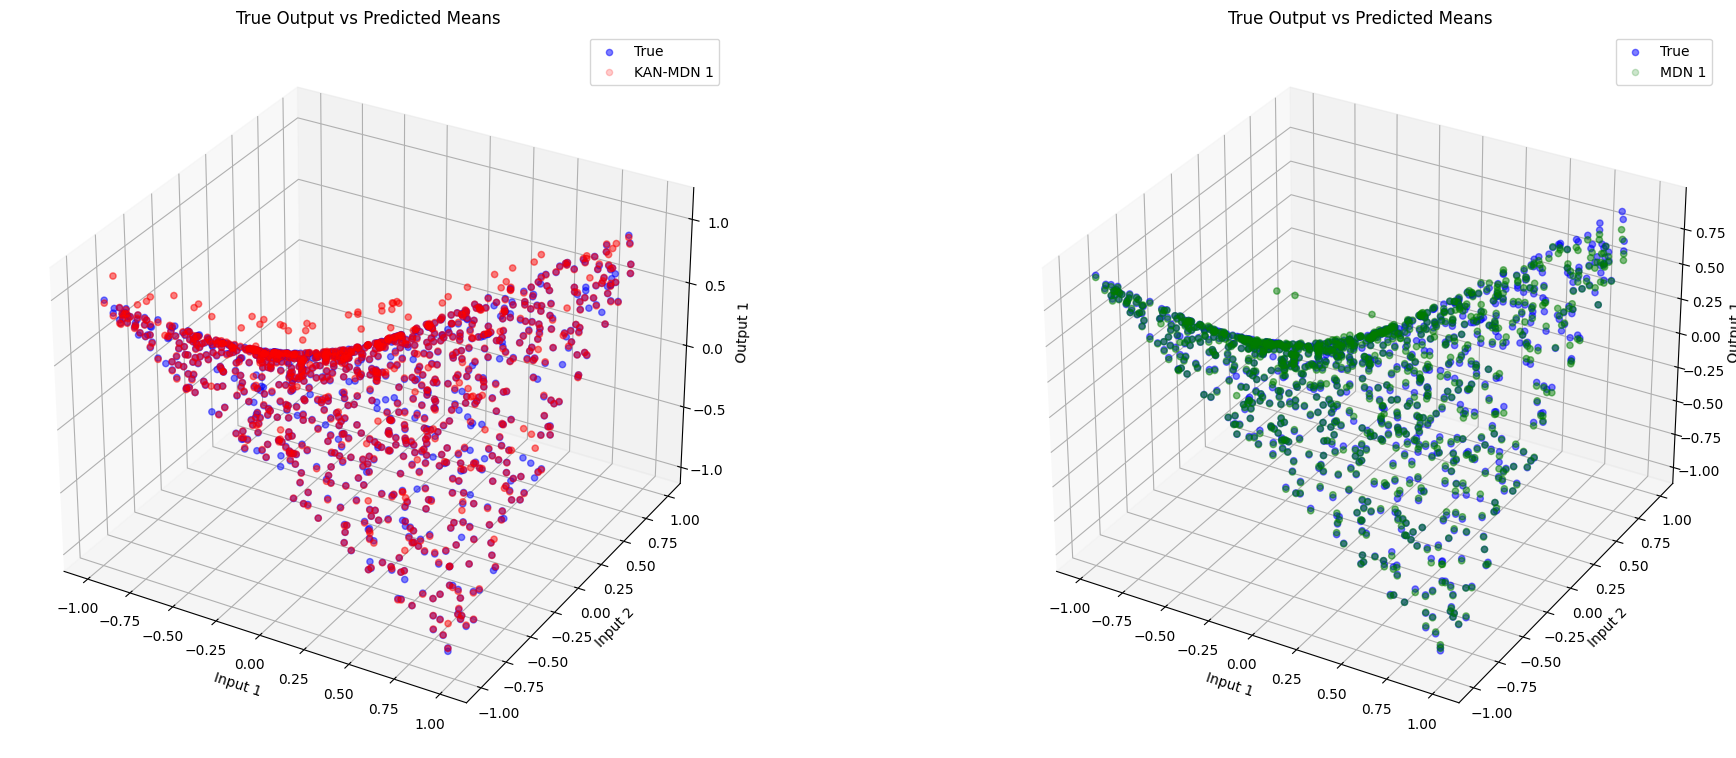

In [393]:
fig = plt.figure(figsize=(20, 15))
# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(x3[:, 0], x3[:, 1], y3, c='b', alpha=0.5, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(x3[:, 0], x3[:, 1], samples_kan3.detach().cpu(), c='r', alpha=0.2, label=f'KAN-MDN {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_zlabel('Output 1')
ax1.set_title('True Output vs Predicted Means')
ax1.legend()



# Plot for the first output dimension
ax2 = fig.add_subplot(222, projection='3d')
scatter = ax2.scatter(x3[:, 0], x3[:, 1], y3, c='b', alpha=0.5, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax2.scatter(x3[:, 0], x3[:, 1], samples_3.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
ax2.set_xlabel('Input 1')
ax2.set_ylabel('Input 2')
ax2.set_zlabel('Output 1')
ax2.set_title('True Output vs Predicted Means')
ax2.legend()
plt.tight_layout()
plt.show()

In [385]:
multikan_4 = MultivariateKANMixtureDensityNetwork(input_dim=x4.shape[1], 
                                                  output_dim=1, 
                                                  hidden_dim=30, 
                                                  n_mixtures=3, 
                                                  grid_size=5, 
                                                  spline_order=3).to(device)

multimdn_4 = MixtureDensityNetwork(input_dim=x4.shape[1], 
                                 output_dim=1, 
                                 hidden_dim=30, 
                                 n_mixtures=3, 
                                 n_hidden_layers=2).to(device)  # the kan also has 2 hidden layers implicitly

In [386]:

optimizerkan_4 = torch.optim.Adam(params=multikan_4.parameters(), 
                             lr=0.001)

optimizermdn_4 = torch.optim.Adam(params=multimdn_4.parameters(), 
                             lr=0.001)

In [387]:
pi_kan4, mu_kan4, sigma_kan4 = training_process(multikan_4, mdn_loss, optimizerkan_4, 500, x4.to(device), y4.to(device))

Epoch: 0 | Loss: 2.27634
Epoch: 100 | Loss: -1.65911
Epoch: 200 | Loss: -1.96477
Epoch: 300 | Loss: -1.46003
Epoch: 400 | Loss: -3.88619


In [388]:

pi_4, mu_4, sigma_4 = training_process(multimdn_4, mdn_loss, optimizermdn_4, 500, x4.to(device), y4.to(device))

Epoch: 0 | Loss: 2.32478
Epoch: 100 | Loss: -0.05276
Epoch: 200 | Loss: -3.75854
Epoch: 300 | Loss: -3.70234
Epoch: 400 | Loss: -3.29489


In [389]:
samples_kan4 = sample_from_mdn(pi_kan4, mu_kan4, sigma_kan4, num_samples=1).reshape(-1, 1)
samples_4 = sample_from_mdn(pi_4, mu_4, sigma_4 , num_samples=1).reshape(-1, 1)

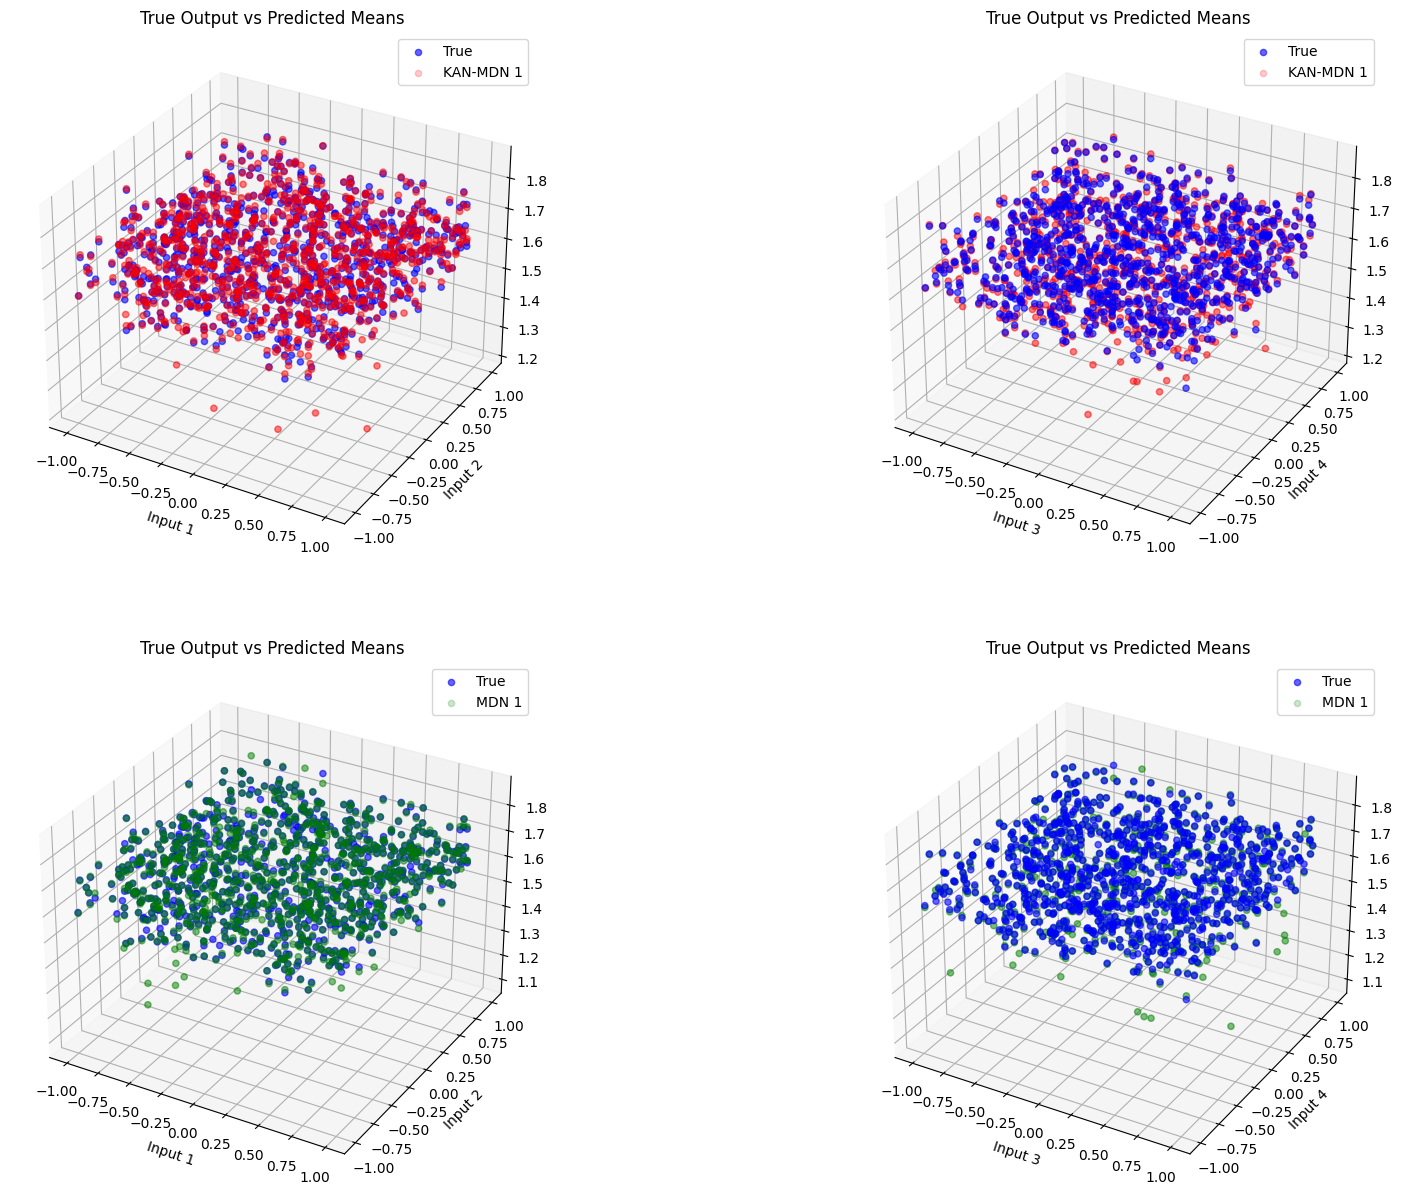

In [397]:
# Create 3D scatter plots
fig = plt.figure(figsize=(20, 15))

# X_train, Y_train, X_test, Y_test = X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy(), X_test.detach().cpu().numpy(), Y_test.detach().cpu().numpy()
# pi, mu, sigma = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()

# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(x4[:, 0], x4[:, 1], y4, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(x4[:, 0], x4[:, 1], samples_kan4.detach().cpu(), c='r', alpha=0.2, label=f'KAN-MDN {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_title('True Output vs Predicted Means')
ax1.legend()

# Plot for the second output dimension
ax2 = fig.add_subplot(222, projection='3d')
scatter = ax2.scatter(x4[:, 2], x4[:, 3], y4, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax2.scatter(x4[:, 2], x4[:, 3], samples_kan4.detach().cpu(), c='r', alpha=0.2, label=f'KAN-MDN {i+1}' if i == 0 else "")
ax2.set_xlabel('Input 3')
ax2.set_ylabel('Input 4')
ax2.set_title('True Output vs Predicted Means')
ax2.legend()

# Plot for the second output dimension
ax3 = fig.add_subplot(223, projection='3d')
scatter = ax3.scatter(x4[:, 0], x4[:, 1], y4, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax3.scatter(x4[:, 0], x4[:, 1], samples_4.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
ax3.set_xlabel('Input 1')
ax3.set_ylabel('Input 2')
ax3.set_title('True Output vs Predicted Means')
ax3.legend()


# Plot for the second output dimension
ax4 = fig.add_subplot(224, projection='3d')
scatter = ax4.scatter(x4[:, 2], x4[:, 3], y4, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax4.scatter(x4[:, 2], x4[:, 3], samples_4.detach().cpu(), c='g', alpha=0.2, label=f'MDN {i+1}' if i == 0 else "")
ax4.set_xlabel('Input 3')
ax4.set_ylabel('Input 4')
ax4.set_title('True Output vs Predicted Means')
ax4.legend()



In [398]:
multikan_5 = MultivariateKANMixtureDensityNetwork(input_dim=x5.shape[1], 
                                                  output_dim=1, 
                                                  hidden_dim=30, 
                                                  n_mixtures=3, 
                                                  grid_size=5, 
                                                  spline_order=3).to(device)

multimdn_5 = MixtureDensityNetwork(input_dim=x5.shape[1], 
                                 output_dim=1, 
                                 hidden_dim=30, 
                                 n_mixtures=3, 
                                 n_hidden_layers=2).to(device)  # the kan also has 2 hidden layers implicitly

In [399]:

optimizerkan_5 = torch.optim.Adam(params=multikan_5.parameters(), 
                             lr=0.001)

optimizermdn_5 = torch.optim.Adam(params=multimdn_5.parameters(), 
                             lr=0.001)

In [400]:
pi_kan5, mu_kan5, sigma_kan5 = training_process(multikan_5, mdn_loss, optimizerkan_5, 500, x5.to(device), y5.to(device))

Epoch: 0 | Loss: 2.34102
Epoch: 100 | Loss: 0.88967
Epoch: 200 | Loss: 0.51630
Epoch: 300 | Loss: -0.15782
Epoch: 400 | Loss: -1.37709


In [401]:

pi_5, mu_5, sigma_5 = training_process(multimdn_5, mdn_loss, optimizermdn_5, 500, x5.to(device), y5.to(device))

Epoch: 0 | Loss: 2.23294
Epoch: 100 | Loss: 0.96944
Epoch: 200 | Loss: 0.68699
Epoch: 300 | Loss: 0.51860
Epoch: 400 | Loss: 0.39819


In [402]:
samples_kan5 = sample_from_mdn(pi_kan5, mu_kan5, sigma_kan5, num_samples=1).reshape(-1, 1)
samples_5 = sample_from_mdn(pi_5, mu_5, sigma_5 , num_samples=1).reshape(-1, 1)

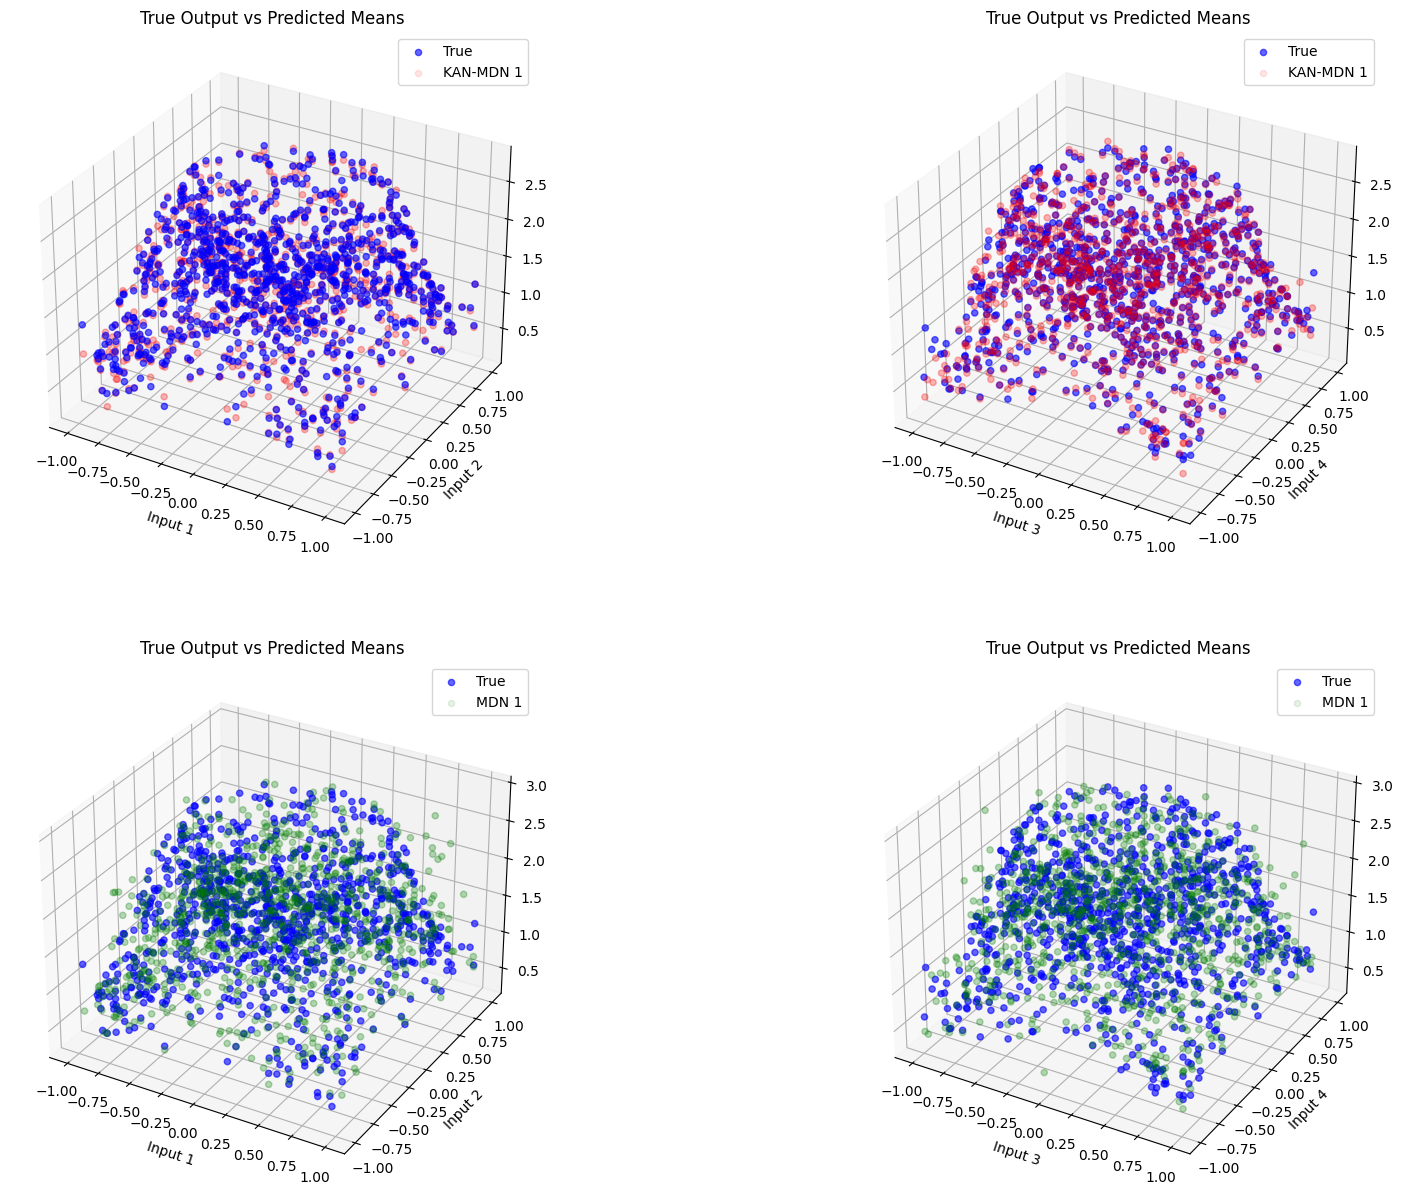

In [405]:
# Create 3D scatter plots
fig = plt.figure(figsize=(20, 15))

# X_train, Y_train, X_test, Y_test = X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy(), X_test.detach().cpu().numpy(), Y_test.detach().cpu().numpy()
# pi, mu, sigma = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()

# Plot for the first output dimension
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(x5[:, 0], x5[:, 1], y5, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax1.scatter(x5[:, 0], x5[:, 1], samples_kan5.detach().cpu(), c='r', alpha=0.1, label=f'KAN-MDN {i+1}' if i == 0 else "")
ax1.set_xlabel('Input 1')
ax1.set_ylabel('Input 2')
ax1.set_title('True Output vs Predicted Means')
ax1.legend()

# Plot for the second output dimension
ax2 = fig.add_subplot(222, projection='3d')
scatter = ax2.scatter(x5[:, 2], x5[:, 3], y5, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax2.scatter(x5[:, 2], x5[:, 3], samples_kan5.detach().cpu(), c='r', alpha=0.1, label=f'KAN-MDN {i+1}' if i == 0 else "")
ax2.set_xlabel('Input 3')
ax2.set_ylabel('Input 4')
ax2.set_title('True Output vs Predicted Means')
ax2.legend()

ax3 = fig.add_subplot(223, projection='3d')
scatter = ax3.scatter(x5[:, 0], x5[:, 1], y5, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax3.scatter(x5[:, 0], x5[:, 1], samples_5.detach().cpu(), c='g', alpha=0.1, label=f'MDN {i+1}' if i == 0 else "")
ax3.set_xlabel('Input 1')
ax3.set_ylabel('Input 2')
ax3.set_title('True Output vs Predicted Means')
ax3.legend()

# Plot for the second output dimension
ax4 = fig.add_subplot(224, projection='3d')
scatter = ax4.scatter(x5[:, 2], x5[:, 3], y5, c='b', alpha=0.6, label='True')
for i in range(mu.shape[1]):  # For each mixture component
    ax4.scatter(x5[:, 2], x5[:, 3], samples_5.detach().cpu(), c='g', alpha=0.1, label=f'MDN {i+1}' if i == 0 else "")
ax4.set_xlabel('Input 3')
ax4.set_ylabel('Input 4')
ax4.set_title('True Output vs Predicted Means')
ax4.legend()

#### Compare 2nd layer weights

We can confirm from the KAN paper that most of the work is done by the base function <br>
compared to the spline weights. Compare that to the MDN which has stronger weights overall.

C:\Users\jako\AppData\Local\Temp\ipykernel_4884\2033981490.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


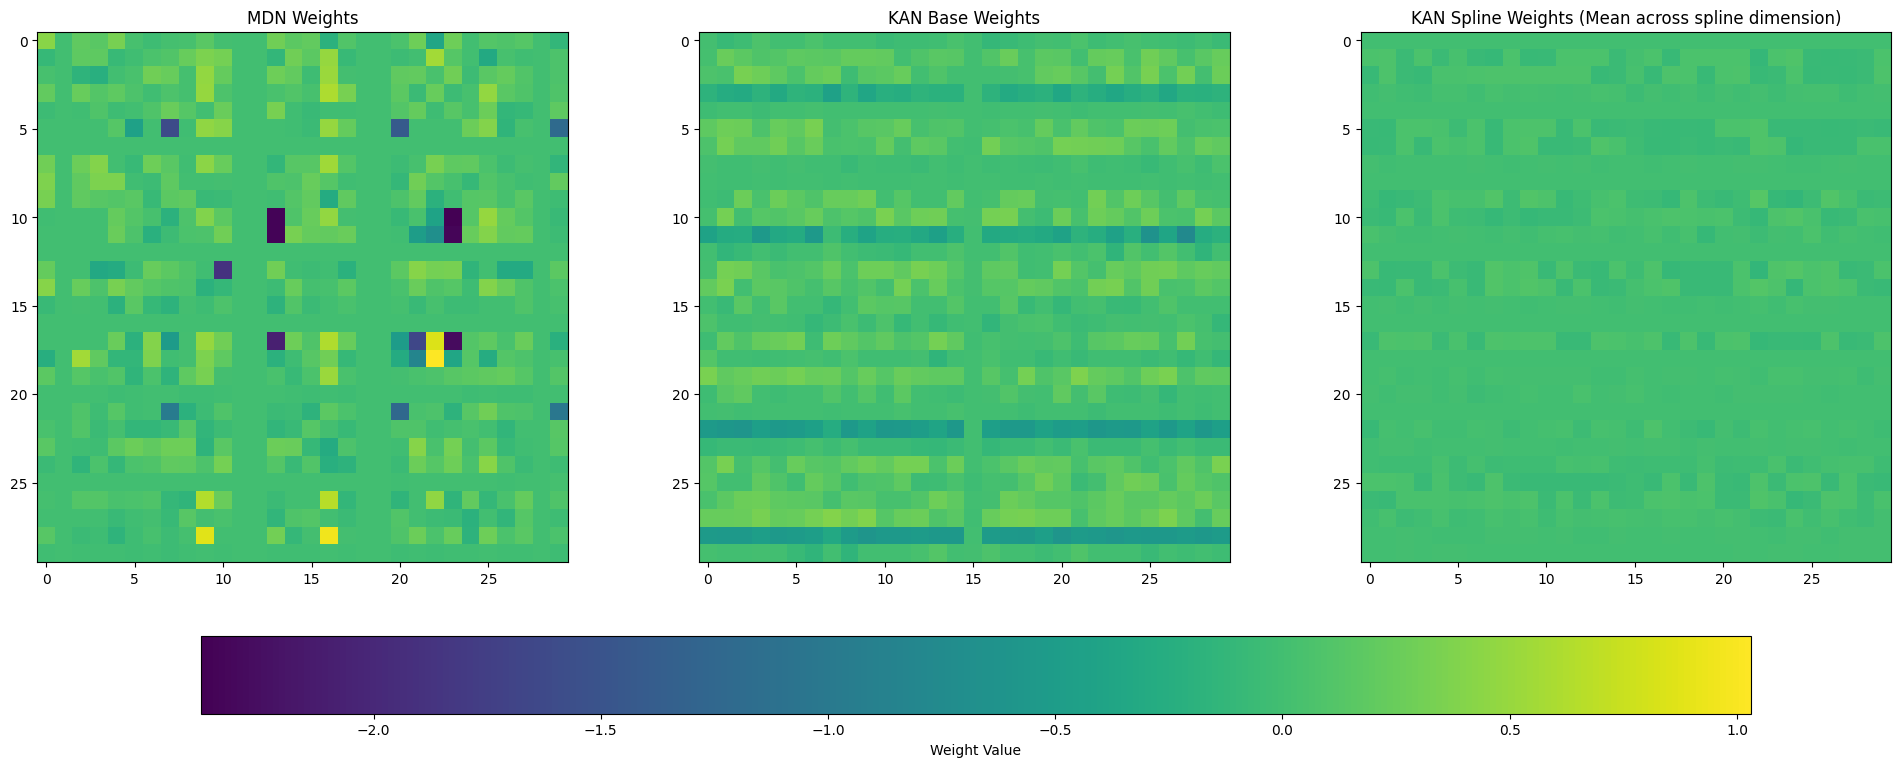

In [290]:

# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Get the data for both plots
mdn_data = multimdn.hidden_block[2].weight.detach().cpu().numpy()
kan_data = multikan.hidden_block[2].base_weight.detach().cpu().numpy()
kan_splines = multikan.hidden_block[2].spline_weight.detach().cpu().numpy().mean(axis=2)
# Find the global min and max for consistent color scaling
vmin = min(mdn_data.min(), kan_data.min())
vmax = max(mdn_data.max(), kan_data.max())

# First subplot
im1 = ax1.imshow(mdn_data, vmin=vmin, vmax=vmax)
ax1.set_title('MDN Weights')

# Second subplot
im2 = ax2.imshow(kan_data, vmin=vmin, vmax=vmax)
ax2.set_title('KAN Base Weights')

im3 = ax3.imshow(kan_splines, vmin=vmin, vmax=vmax)
ax3.set_title('KAN Spline Weights (Mean across spline dimension)')



# Add a colorbar that refers to both subplots
cbar = fig.colorbar(im2, ax=[ax1, ax2, ax3], orientation='horizontal', pad=-0.5)
cbar.set_label('Weight Value')

# Adjust layout and display
plt.tight_layout()

C:\Users\jako\AppData\Local\Temp\ipykernel_4884\83606960.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


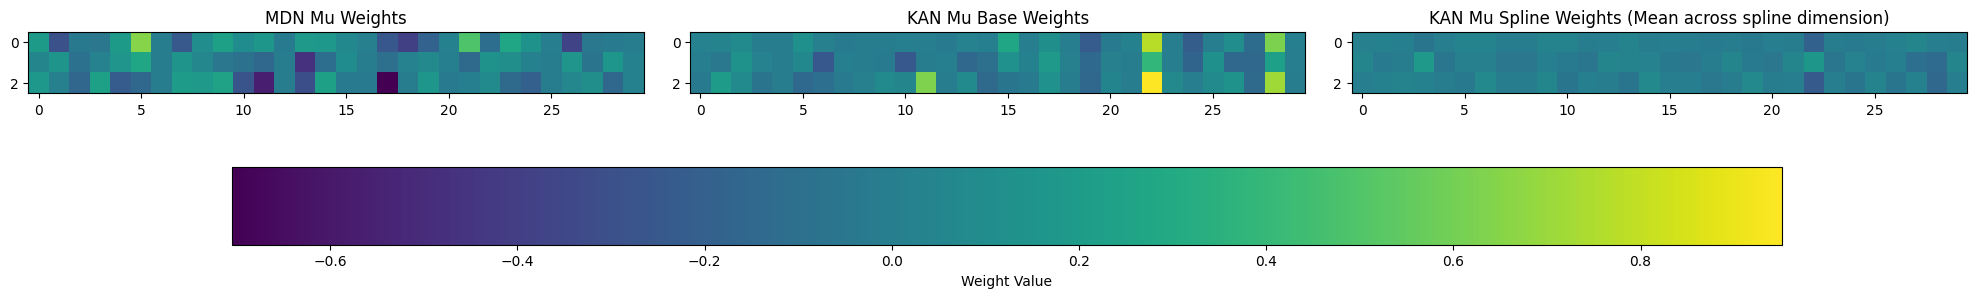

In [291]:

# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Get the data for both plots
mdn_data = multimdn.mu.weight.detach().cpu().numpy()
kan_data = multikan.mu.base_weight.detach().cpu().numpy()
kan_splines = multikan.mu.spline_weight.detach().cpu().numpy().mean(axis=2)
# Find the global min and max for consistent color scaling
vmin = min(mdn_data.min(), kan_data.min())
vmax = max(mdn_data.max(), kan_data.max())

# First subplot
im1 = ax1.imshow(mdn_data, vmin=vmin, vmax=vmax)
ax1.set_title('MDN Mu Weights')

# Second subplot
im2 = ax2.imshow(kan_data, vmin=vmin, vmax=vmax)
ax2.set_title('KAN Mu Base Weights')

im3 = ax3.imshow(kan_splines, vmin=vmin, vmax=vmax)
ax3.set_title('KAN Mu Spline Weights (Mean across spline dimension)')



# Add a colorbar that refers to both subplots
cbar = fig.colorbar(im2, ax=[ax1, ax2, ax3], orientation='horizontal', pad=-0.5)
cbar.set_label('Weight Value')

# Adjust layout and display
plt.tight_layout()

C:\Users\jako\AppData\Local\Temp\ipykernel_4884\1471781519.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


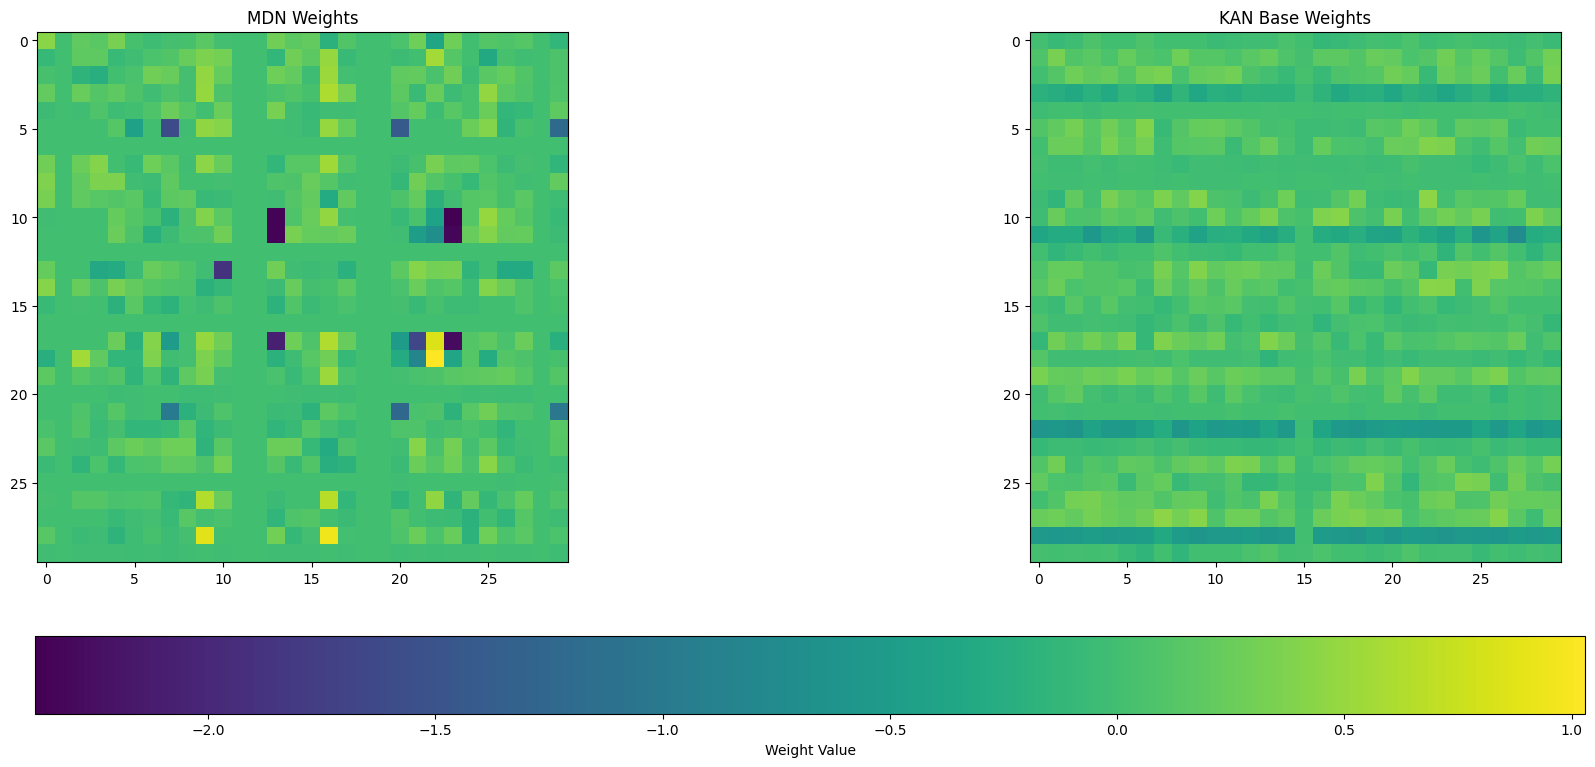

In [292]:

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Get the data for both plots
mdn_data = multimdn.hidden_block[2].weight.detach().cpu().numpy()
kan_data = multikan.hidden_block[2].base_weight.detach().cpu().numpy() + multikan.hidden_block[2].spline_weight.detach().cpu().numpy().mean(axis=2)

# Find the global min and max for consistent color scaling
vmin = min(mdn_data.min(), kan_data.min())
vmax = max(mdn_data.max(), kan_data.max())

# First subplot
im1 = ax1.imshow(mdn_data, vmin=vmin, vmax=vmax)
ax1.set_title('MDN Weights')

# Second subplot
im2 = ax2.imshow(kan_data, vmin=vmin, vmax=vmax)
ax2.set_title('KAN Base Weights')



# Add a colorbar that refers to both subplots
cbar = fig.colorbar(im2, ax=[ax1, ax2], orientation='horizontal', pad=-0.5)
cbar.set_label('Weight Value')

# Adjust layout and display
plt.tight_layout()

In [341]:
multikan.hidden_block[2].spline_weight.detach().cpu().numpy().reshape(-1, 30).shape

(450, 30)

In [363]:
pe = []
sc = []
for row in range(multikan.mu.spline_weight.detach().cpu().numpy().shape[0]):
    tt = ordpy.complexity_entropy(multikan.mu.spline_weight.detach().cpu().numpy()[row, :])
    print(f"Row: {row} of KAN 2nd layer \n \t Permutation Entropy: {tt[0]} | Statistical Complexity: {tt[1]}")

    pe.append(tt[0])
    sc.append(tt[1])



Row: 0 of KAN 2nd layer 
 	 Permutation Entropy: 0.9662311732217843 | Statistical Complexity: 0.030639167573175828
Row: 1 of KAN 2nd layer 
 	 Permutation Entropy: 0.9461796190098776 | Statistical Complexity: 0.0486816853963734
Row: 2 of KAN 2nd layer 
 	 Permutation Entropy: 0.9526796761102206 | Statistical Complexity: 0.04382200541883234


Text(0.5, 1.0, 'MDN 2nd layer Base Weights')

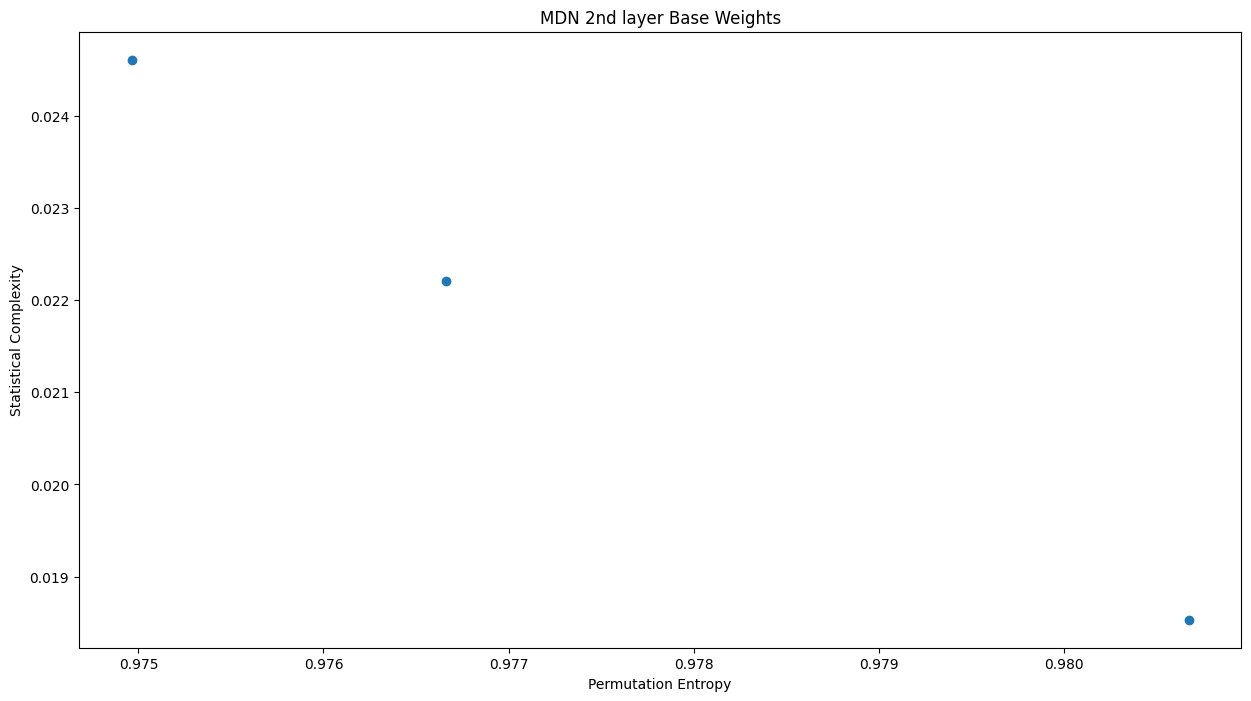

In [361]:
plt.figure(figsize=(15, 8))
plt.scatter(pe, sc)
plt.xlabel("Permutation Entropy")
plt.ylabel("Statistical Complexity")

plt.title("MDN 2nd layer Base Weights")

Text(0.5, 1.0, 'KAN Mu Spline Weights')

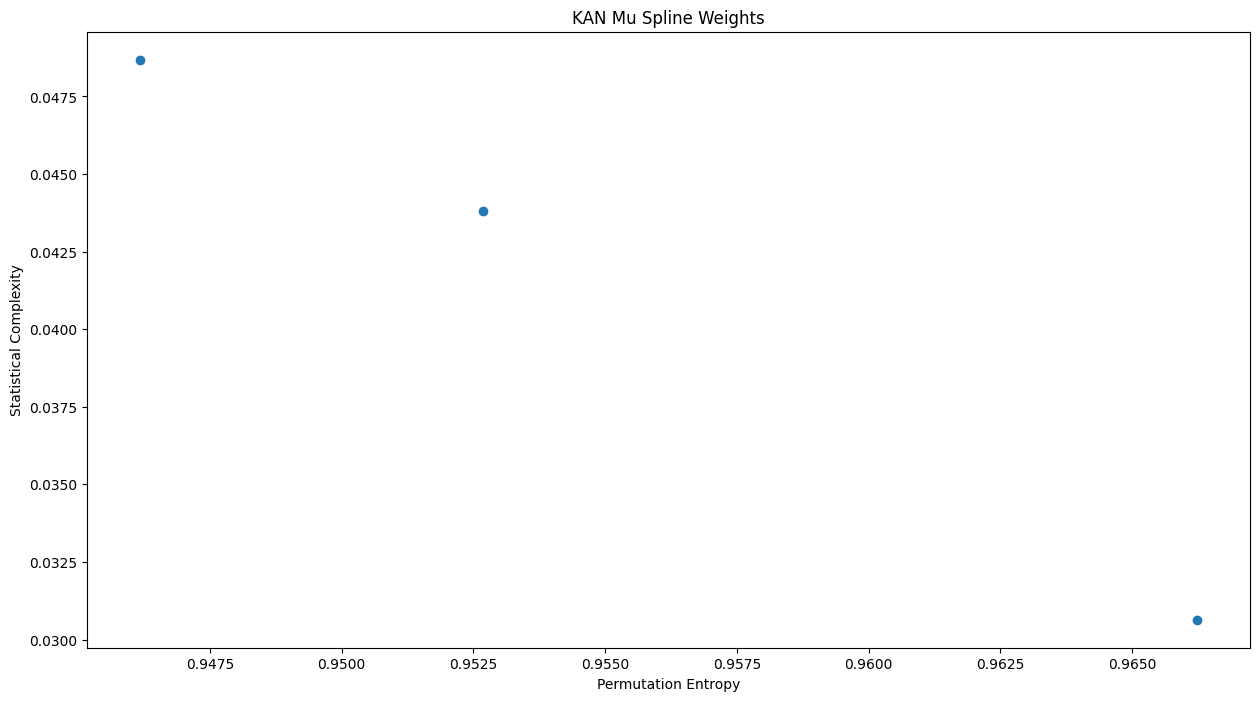

In [364]:
plt.figure(figsize=(15, 8))
plt.scatter(pe, sc)
plt.xlabel("Permutation Entropy")
plt.ylabel("Statistical Complexity")

plt.title("KAN Mu Spline Weights")

In [187]:
import ordpy

In [293]:
ordpy.complexity_entropy(multikan.hidden_block[2].base_weight.detach().cpu().numpy().flatten())

(0.9997675274602102, 0.00023002489419459378)

In [294]:
ordpy.complexity_entropy(multikan.hidden_block[2].spline_weight.detach().cpu().numpy().mean(axis=2).flatten())

(0.9989736375074564, 0.0010131824713198855)

In [295]:
ordpy.complexity_entropy(multimdn.hidden_block[2].weight.detach().cpu().numpy().flatten())

(0.9969428577284344, 0.002998711845720332)

In [296]:
ordpy.complexity_entropy(multimdn.mu.weight.detach().cpu().numpy().flatten()), ordpy.complexity_entropy(multikan.mu.base_weight.detach().cpu().numpy().flatten()), ordpy.complexity_entropy(multikan.sigma.base_weight.detach().cpu().numpy().flatten())

((0.987404139836381, 0.012623179088194639),
 (0.9935309873141703, 0.006418932219490391),
 (0.9740852876150845, 0.025081773465824977))

In [321]:
ordpy.complexity_entropy(multikan.mu.spline_weight.detach().cpu().numpy().flatten()), ordpy.complexity_entropy(multikan.sigma.spline_weight.detach().cpu().numpy().flatten()), ordpy.complexity_entropy(multikan.pi.spline_weight.detach().cpu().numpy().flatten())

(0.9616077393960172,
 (0.9360838192699231, 0.057012033854582166),
 (0.9622475629395586, 0.0343770962698606))

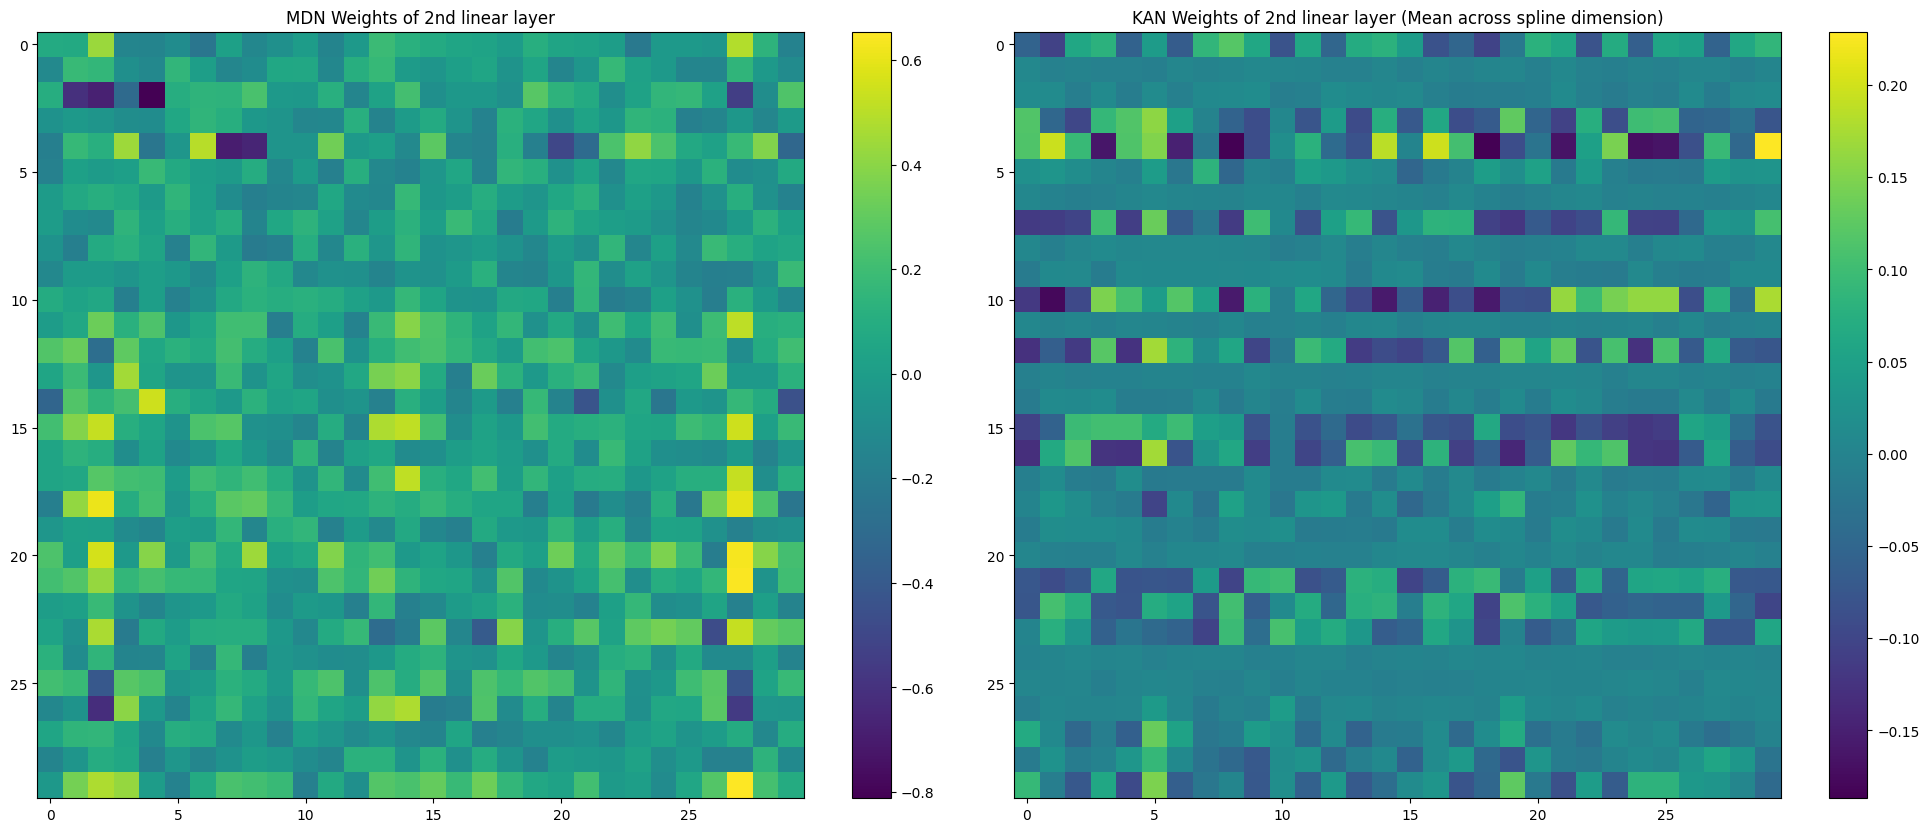

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


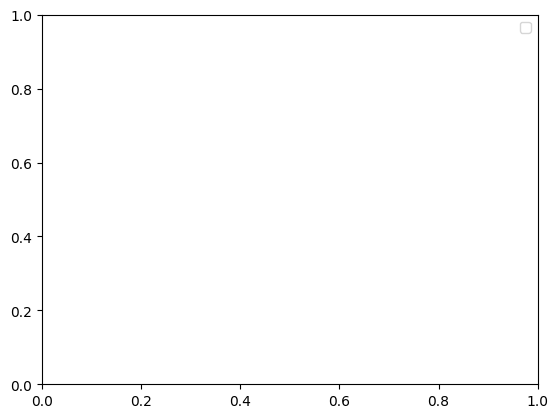

In [130]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First subplot
im1 = ax1.imshow(multimdn.hidden_block[2].weight.detach().cpu().numpy(),)
ax1.set_title('MDN Weights of 2nd linear layer')
fig.colorbar(im1, ax=ax1)

# Second subplot
im2 = ax2.imshow(multikan.hidden_block[2].spline_weight.detach().cpu().numpy().mean(axis=2),)
ax2.set_title('KAN Weights of 2nd linear layer (Mean across spline dimension)')
fig.colorbar(im2, ax=ax2)

# Adjust layout and display
plt.tight_layout()
plt.show()
plt.legend()